# Введение

В этой части работы я использую таблицу ```steel_features.csv```, полученную из предобработанных данных в прошлом задании для обучения и исследования разных моделей. Оснавная задача на этом этапе: подобрать модель лучше всего работающую на имеющихся данных. Целевой метрикой у нас будет MAE. 

Задача проекта — получить величину MAE ≤ 6.8. 

В качестве содержания для в данной части работы я буду использовать план, составленный в прошлой части, добавив в него пару дополнительных пунктов.

# Содержание

1. <b>[Подготовка признаков.](#Подготовка-признаков)</b> Полученные данные я разделю на обучающие признаки и целевой. Целевым признаком будет являться окончательная температура стали перед розливом.
2. <b>[Выбор набора моделей.](#Выбор-набора-моделей)</b> Я возьму несколько регрессионных моделей, использующих разные алгоритмы (линейные, древо решений, ансамблевые модели, метод ближайших соседей). Так же попробую модели с применением градиентного бустинга.
3. <b>[Подбор оптимальных гиперпараметров моделей и определение их качества.](#Подбор-оптимальных-гиперпараметров-моделей-и-определение-их-качества)</b> Используя кросс-валидацию, подберу оптимальные гиперпараметры каждой модели и определю качество каждой модели согласно требуемой метрики.
4. <b>[Выбор и анализ наилучшей модели.](#Выбор-и-анализ-наилучшей-модели)</b> Сравню качесвто моделей используя требуемую метрику и выберу модель наиболее подходящую к задаче. Проанализирую веса признаков, определенные моделью, сделаю выводы, возможно оптимизирую процесс обработки признаков.
5. <b>[Доработка модели для применения бизнесом.](#Доработка-модели-для-применения-бизнесом)</b>
6.  <b>[Отчет по решению.](#Отчет-по-решению)</b>

# Импорты

In [1]:
#библиотеки
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
#всякое
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
#модели
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
#метрики
from sklearn.metrics import mean_absolute_error
#константы
RS = 12345

---

## Подготовка признаков
[вернуться к содержанию](#Содержание)

In [ ]:
data = pd.read_csv('steel_features.csv')

In [3]:
data

,key,active_power,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,...,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,gas_1,start_temp,target_temp
0,1,4.878147,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986,1571.0,1613.0
1,2,3.052598,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561,1581.0,1602.0
2,3,2.525882,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793,1596.0,1599.0
3,4,3.209250,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219,1601.0,1625.0
4,5,3.347173,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692,1576.0,1602.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2201,2495,3.210690,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.125735,1570.0,1591.0
2202,2496,4.203064,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.412616,1554.0,1591.0
2203,2497,2.212379,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.271699,1571.0,1589.0
2204,2498,3.408725,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.953657,1591.0,1594.0


Разобьем набор данных на признаки и целевой признак. Кроме того из обучающих признаков необходимо удалить номер партии (столбец "key"), так как этот признак не даст модели полезной для обучения информации.

In [4]:
X = data.drop(['key', 'target_temp'], axis=1)
y = data['target_temp']

Теперь уже полученные фичи и таргеты поделим на обучающие и тестовые, на которых будем проверять эффективность подобранной модели.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RS)

---

## Выбор набора моделей
[вернуться к содержанию](#Содержание)

Я собираюсь использовать несколько регрессионных моделей для того чтобы выбрать лучшую для нашей задачи. Вот те модели, которые я собираюсь проверить:
* DummyRegressor - медианная модель, результаты ее предсказаний я буду использовать для оценки адекватности остальных моделей.
* LinearRegression - классическая модель линейной регрессии
* DecisionTreeRegressor - модель дерева решений
* RandomForestRegressor - модель случайного леса
* KNeighborsRegressor - регрессионная модель k ближайших соседей
* LGBMRegressor - модель, использующая градиентный бустинг

Подготовим модели. Создадим словарь, в который внесем все модели и гиперпараметры, с которыми хотим исследовать модели. Этот словарь будем использовать при кросс-валидации в следующем разделе. Формат записи в словаре следующий:  
```'Наимнование модели': [Сама модель со статичными параметрами, {словарь диапазонами подбираемых гиперпараметров}]```

In [6]:
models = {'DummyRegressor': [DummyRegressor(strategy='median'), {}],
          'LinearRegression': [LinearRegression(n_jobs=-1), {}],
          'DecisionTreeRegressor': [DecisionTreeRegressor(random_state=RS), {'max_depth': range(3, 12)}],
          'RandomForestRegressor': [RandomForestRegressor(random_state=RS, n_jobs=-1), {'max_depth': range(3, 12),
                                                                                        'n_estimators': range(100, 501, 100)}],
          'KNeighborsRegressor': [KNeighborsRegressor(n_jobs=-1), {'n_neighbors' : [5,7,11,13],
                                                                   'weights' : ['uniform','distance'],
                                                                   'metric' : ['minkowski','euclidean','manhattan']}],
          'LGBMRegressor': [LGBMRegressor(random_state=RS, n_jobs=-1), {'max_depth': range(3, 12),
                                                                        'n_estimators': range(100, 501, 100),
                                                                        'num_leaves': range(16, 47, 15),
                                                                        'learning_rate': np.arange(0.01, 0.20, 0.05)}]}

---

## Подбор оптимальных гиперпараметров моделей и определение их качества
[вернуться к содержанию](#Содержание)

Напишем цикл, который будет перебирать все модели в словаре выше и отправлять их и сетку гиперпараметров на кросс-валидацию. По каждой модели цикл будет выводить наилучшую достигнутую метрику и гиперпараметры, позволившие достигнуть эту метрику.

In [7]:
for key in models.keys():
    cv = GridSearchCV(models[key][0], models[key][1], scoring='neg_mean_absolute_error', cv=5)
    cv.fit(X_train, y_train)
    print('Применяемая модель: {}'.format(key))
    print('Наилучшая величина MAE на кросс-валидации: {:.2f}'.format(-cv.best_score_))
    print('Гиперпараметры, при которых был достигнут наилучший размер метрики:')
    print(cv.best_params_)
    print()

Применяемая модель: DummyRegressor
Наилучшая величина MAE на кросс-валидации: 8.00
Гиперпараметры, при которых был достигнут наилучший размер метрики:
{}

Применяемая модель: LinearRegression
Наилучшая величина MAE на кросс-валидации: 6.35
Гиперпараметры, при которых был достигнут наилучший размер метрики:
{}

Применяемая модель: DecisionTreeRegressor
Наилучшая величина MAE на кросс-валидации: 6.88
Гиперпараметры, при которых был достигнут наилучший размер метрики:
{'max_depth': 6}

Применяемая модель: RandomForestRegressor
Наилучшая величина MAE на кросс-валидации: 5.89
Гиперпараметры, при которых был достигнут наилучший размер метрики:
{'max_depth': 10, 'n_estimators': 100}

Применяемая модель: KNeighborsRegressor
Наилучшая величина MAE на кросс-валидации: 7.32
Гиперпараметры, при которых был достигнут наилучший размер метрики:
{'metric': 'manhattan', 'n_neighbors': 13, 'weights': 'distance'}

Применяемая модель: LGBMRegressor
Наилучшая величина MAE на кросс-валидации: 5.88
Гиперпара

---

## Выбор и анализ наилучшей модели
[вернуться к содержанию](#Содержание)

Мы получили результаты кросс-валидации. Среди них не только наилучшие показатили небходимой метрики каждой модели, но и значения гиперпараметров, при которых получены эти значения метрик.

Сразу можно заметить, что все предсказательные модели адекватны - они все дают результаты лучше медианной модели.

Из всех результатов можно выделить две модели: модель случайного леса, и регрессионная модель библиотеки LightGBM. Их результаты заметно лучше всех остальных, и очень близки друг к другу.

Проверим две эти модели на тестовых данных, чтобы принять окончательное решение.

In [14]:
forest = RandomForestRegressor(random_state=RS, n_jobs=-1, max_depth=10, n_estimators=100)
forest.fit(X_train, y_train)
forest_pred = forest.predict(X_test)
mae_forest = mean_absolute_error(forest_pred, y_test)
mae_forest

6.145715276494771

In [15]:
lgbm = LGBMRegressor(random_state=RS, n_jobs=-1, max_depth=8, n_estimators=500, num_leaves=16, learning_rate=0.01)
lgbm.fit(X_train, y_train)
lgbm_pred = lgbm.predict(X_test)
mae_lgbm = mean_absolute_error(lgbm_pred, y_test)
mae_lgbm

6.0664978910562555

На тестовых данных с заметным перевесом по качеству лидирует модель с градиентным бустингом. Изучим ее. Посмотрим на важности признаков, которые модель присвоила. По сути это это вектор ввесов w каждого из признаков. Для удобства сранения переведем веса в проценты, где сто процентов - суммарное влияние всех признаков.

In [100]:
lgbm_importances = np.around(lgbm.feature_importances_/lgbm.feature_importances_.sum(), 2)*100
lgbm_importances

array([20.,  3.,  0.,  3.,  2.,  1.,  5.,  0.,  0.,  0.,  0.,  2.,  6.,
        0.,  7.,  4., 10.,  7.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  8.,
       21.])

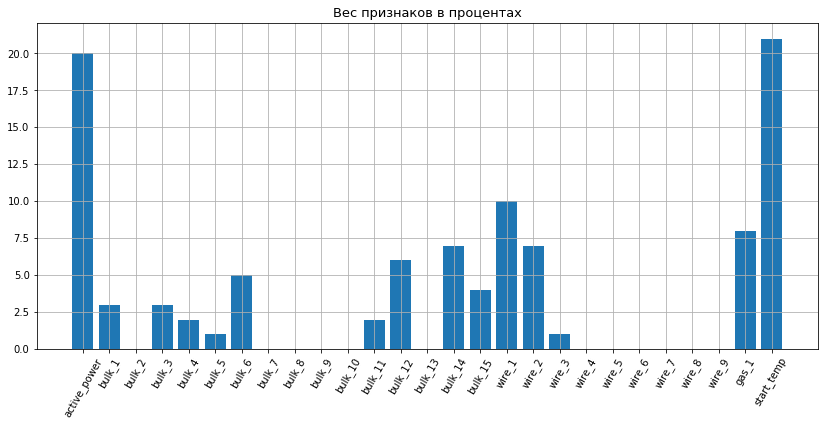

In [103]:
plt.figure(figsize=(14, 6))
plt.bar(X.columns, lgbm_importances)
plt.title('Вес признаков в процентах', size=13)
plt.xticks(rotation=60)
plt.grid()
plt.show()

На графике видно, что выбранной модели для определения итоговой температуры партии наиболее важны начальная температура и количество затрачиваемой на подогрев мощности. В меньшей степени влияют подаваемые присадки. Тем не менее, тройка признаков, сильнее всего влияющих на итоговую температуру партии выглядит так:
* Начальная температура партии (start_temp);
* Активная мощность, затраченная на подогрев (active_power);
* Объем подвнной проводной присадки №1 (wire_1).

У выбранной модели часть признаков (11 штук) вообще не влияет на предсказания модели. Это признаки, описывающие объем некоторых из поданных присадок. Скорее всего это произошло из-за малого количества наблюдений, в которых применялись эти присадки. В дальнейшем хотелось бы иметь наблюдения за более длительный срок, возможно это изменило бы баланс весов в выбраной модели. Не исключено, что больший объем данных приведет к выбору другой модели с иным набором гиперпараметров.

Для улучшения качества предсказаний можно отдельно выполнить кросс-валидацию уже выбранной модели с более широкими диапазонами гиперпараметров. Таким образом, я уверен, на этой модели можно досчитчь величины МАЕ <6 на тестовых данных. Делать это нужно исходя из ресурсо- и времязатрат и потребности бизнеса. В настоящем проекте я остановлюсь на достигнутом результате.

---

## Доработка модели для применения бизнесом
[вернуться к содержанию](#Содержание)

Для применения модели в бизнесс-процессах необходимо обучить полученную модель на всём наборе имеющихся данных.

In [106]:
steel_model_final = lgbm.fit(X, y)

Модель готова. Теперь, передавая в нее исходные данные, предобработанные по той же схеме, что была в первом разделе этого проекта, заказчик будет получать прогнозируемую температуру партии. Заказчик может привести окончательную температуру партии к оптимальной, подбирая входные параметры, к примеру, активную мощность, начальную температуру партии, объем инертного газа.

```target_temp = steel_model_final.predict(X_to_predict)```

## Отчет по решению
[вернуться к содержанию](#Содержание)

Для отчета я воспользуюсь планом работы, который составил ранее, и который служит тут содержанием. Все пункты плана были успешно выполнены. По каждой части плана дам развернутый комментарий, что было сделано, какие инструменты применены, чего удалось достичь.

0. <b>Подготовка данных и создание набора данных для дальнейшей работы.</b>  
На данном этапе мной были получены сырые данные, выгруженные из разных таблиц базы данных техпроцесса. Данные содержали в себе пропуски, ошибки. Информация по некоторым партиям не подходила для нашей задачи совершенно. Каждая из таблиц была очищена от пропусков и ошибок, данные были статистически исследованы. По большинству таблиц была проверена корреляция имеющихся признаков. Так же, был отобран список подходящих для анализа партий, по которому в результате был составлен набор данных для обработки инструментами машинного обучения. Набор данных был сохранен в отдельный csv-файл.  


1. <b>Подготовка признаков.</b>  
Полученный на прошлом этапе набор данных был загружен из csv-файла. Поделён на признаки и целевой признак. Кроме того, на этом этапе был удален столбец с номером партии, по недосмотру оставшийся в данных. Инструментом ```train_test_split``` библиотеки scikit-learn  признаки и целевой признак были поделены на обучающую-валидационную и тестовую выборки в пропорции 75%/25%.  


2. <b>Выбор набора моделей.</b>  
Для использования мной был выбран набор регрессионных моделей разных принципов действия из библиотек scikit-learn и lightgbm. Модели были собраны в отдельную переменную-словарь, где помимо самих моделей были отобраны гиперпараметры и заданы диапазоны  внутри которых будет осуществляться подбор оптимальных гиперпараметров. Помимо реальных моделей я добавил в набор медианную модель, показания которой использовал для проверки адекватности модели.  


3. <b>Подбор оптимальных гиперпараметров моделей и определение их качества.</b>  
На данном этапе был выполнен подбор оптимальных гиперпараметров каждой модели из словаря из прошлого пункта. Подбор выполнялся инструментом ```GridSearchCV``` из библиотеки scikit-learn. Был выполнен перебор по сетке гиперпараметров всех моделей и подобраны гиперпараметры дающие лучший размер требуемой метрики МАЕ. На данном этапе у меня возникла единственная серьезная проблема на весь проект. Изначально выбранные диапазоны гиперпараметров были очень большими, и поэтому кросс-валидация заняла у меня больше суток. Не дождавшись окончания перебора, я отменил рассчет и уменьшил разброс диапазонов гиперпараметров. Так же время выполнения могло бы снизить уменьшение числа блоков для кросс-валидации (параметр ```cv```). После уменьшения диапазонов, подбор гиперпараметров занял около 4 часов. В результате я получил наилучший размер МАЕ для каждой из моделей в выбранных диапазонах гиперпараметров. Тут я так же сравнил значения метрики с результатами медианной модели, чтобы проверить адекватность модели. Все выбраные модели оказались адекватны.
 
 
4. <b>Выбор и анализ наилучшей модели.</b>  
В результате наилучшие значения метрик были получены на модели случайного леса из библиотеки scikit-learn и регрессионной модели из библиотеки lightgbm. Кстати, я не указал на это в самой работе, но по сути модель lightgbm представляет из себя модель случайного леса, но использует градиентный бустинг. Так что в финал вышли две модели, имеющие один принцип работы.  
Итоговую проверку я выполнял уже на тестовых данных. И здесь модель библиотеки lightgbm показала лучший результат (МАЕ 6.06 против 6.14 у обычного случайного леса).  
Выбрав лучшую модель, я проанализировал веса, которые модель присвоила признакам. На основе весов, я сделал предложения по предобработке данных. Так же указал возможные направления для повышения качества модели.  
В самом конце я подготовил модель для использования бизнесом, обучив ее на всём имеющемся наборе данных.

<b>В результате выполнения работы была выбрана модель и гиперпараметры:</b>  

```LGBMRegressor(random_state=12345, n_jobs=-1, max_depth=8, n_estimators=500, num_leaves=16, learning_rate=0.01)```

<b> Размер целевой метрики составил: МАЕ = 6.06</b> 